In [1405]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj

NFF_PATH = '/home/wwj/Repo/playgrounds/NeuralForceField/'
ODE_PATH = '/home/wwj/Repo/projects/torchdiffeq/'

sys.path.insert(0, NFF_PATH)
sys.path.insert(0, ODE_PATH)
sys.path.insert(0, '../..')

import torch
from torch.optim import Adam
from torchdiffeq import odeint_adjoint as odeint
from torchmd.ode import ODE
from torchmd.hamiltoinians import PairPot, MLP, LennardJones, Buck, LennardJones69
from torchmd.observable import DiffRDF
from torchmd.utils import dump_mov
from nglview import show_ase, show_file, show_mdtraj

from nff.utils.scatter import compute_grad
from nff.nn.layers import GaussianSmearing
from ase import Atoms
from math import sqrt

import matplotlib
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False

In [1406]:
def double_well(x):
    return -x **2 + 1/20 * x**4

def harm(x):
    return 1/2 * x ** 2

def cos_well(x):
    return 4 * np.cos(2 * np.pi * x / np.pi)

    return 4 

In [1056]:
# ground truth 

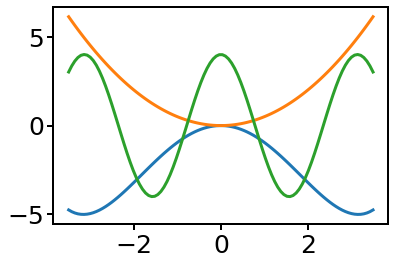

In [1057]:
x = np.linspace(-3.5, 3.5, 100)

plt.plot(x, double_well(x))
plt.plot(x, harm(x))
plt.plot(x, cos_well(x))

In [1059]:
class NHODE(torch.nn.Module):

    def __init__(self, model, mass, target_momentum=4.0, num_chains=2, ttime = 10.0, dt= 0.005, device=0, dim=3,
                 time_dependent=True):
        super().__init__()
        self.model = model  
        self.mass = torch.Tensor(mass).to(device)
        self.time_dependent = time_dependent
    
        self.device = device 
        self.target_momentum = target_momentum
        self.ttime = ttime 
        self.N_dof = mass.shape[0] * dim
        self.target_ke = (0.5 * self.N_dof * self.target_momentum **2 )
        
        self.T = torch.Tensor( [self.target_momentum **2] ).to(device)
        self.num_chains = num_chains
        self.Q = np.array([1,
                   *[1]*(num_chains-1)]) 
        self.Q = torch.Tensor(self.Q).to(device)
        self.dim = dim
        
    def forward(self, t, state):
        # pq are the canonical momentum and position variables
        with torch.set_grad_enabled(True):
            
            N = self.N_dof
            
            pq = state[0]
            
            B = pq.shape[0]
            
            t.requires_grad = True
            pq.requires_grad = True
            t = t.expand(B, 1)
            
            p = pq[:, :N]
            q = pq[:, N:2* N].reshape(-1, self.dim)
            
            sys_ke = 0.5 * (p.reshape(-1, self.dim).pow(2) / self.mass[:, None]).sum(-1) 
            
            # definite all the virtual momentums 
            p_v = pq[:, -self.num_chains:]      
            u = self.model(q, t)
            
            dqdt = (p.reshape(-1, self.dim) / self.mass[:, None])#.reshape(-1)
            dpdt = -compute_grad(inputs=q, output=u).reshape(-1, self.dim) - p_v[:, [0]] * p / self.Q[0]
            
            u_sum = u.sum()
            if self.time_dependent:
                dWdt = compute_grad(inputs=t, output=u_sum) 

            else:
                dWdt = torch.Tensor( [0.0] ).to(self.device) 

            dpvdt_0 = 2 * (sys_ke - self.T * self.N_dof * 0.5) - p_v[:, 0] * p_v[:, 1]/ self.Q[1]
            dpvdt_mid = (p_v[:, :-2].pow(2) / self.Q[:-2] - self.T) - p_v[:, 2:]*p_v[:, 1:-1]/ self.Q[2:]
            dpvdt_last = p_v[:, -2].pow(2) / self.Q[-2] - self.T

        f = torch.cat((dpdt, dqdt, dpvdt_0[:, None], dpvdt_mid, dpvdt_last[:, None]), dim=1)
        dQdt = -dqdt * dpdt
        
        return (f, dWdt, dQdt)
    
class doublewell(torch.nn.Module):
    def __init__(self):
        super(doublewell, self).__init__()

    def forward(self, x, t):
        return double_well(x)
    
class cosinewell(torch.nn.Module):
    def __init__(self):
        super(cosinewell, self).__init__()

    def forward(self, x, t):
        return  4 * torch.cos(2 * np.pi * x / np.pi)

In [1060]:
# generate ground truth data 

In [1061]:
DEVICE = 0
num_chains = 3
tau = 100
dt = 0.05
t_len = int( tau / dt )

class Harmonic1D(torch.nn.Module):
    def __init__(self):
        super(Harmonic1D, self).__init__()

    def forward(self, x, t):
        return 0.5 * 0.25 * x ** 2

#harm1d = Harmonic1D().to(DEVICE)
harm1d = doublewell().to(DEVICE)
#harm1d = cosinewell().to(DEVICE)

f_x = NHODE(harm1d, 
            torch.Tensor([1.0]), 
            ttime=50.0, 
            num_chains=num_chains, 
            device=DEVICE,
            target_momentum=1.0,
            time_dependent=False,
            dim=1).to(DEVICE)

In [1062]:
B = 2**12

# sample position and momentum, p_v is virtual momenta 
p_v = torch.empty(B, 3).normal_(mean=0,std=1)
q = torch.empty(B, 1).normal_(mean=0,std=2) 
p = torch.empty(B, 1).normal_(mean=0,std=1)
W = torch.zeros(B, 1).to(DEVICE)
Q = torch.zeros(B, 1).to(DEVICE)

pq = torch.cat((p, q, p_v), dim=1).to(DEVICE)
pq.requires_grad= True

t = torch.Tensor([dt * i for i in range(t_len)]).to(DEVICE)
t.requires_grad = True

x, W_traj, Q_traj = odeint(f_x, (pq, W, Q), t, method='rk4')

In [1063]:
x.shape

torch.Size([2000, 4096, 5])

In [1064]:
data = x[-200:-1, :, 1].detach().cpu().numpy().reshape(-1)

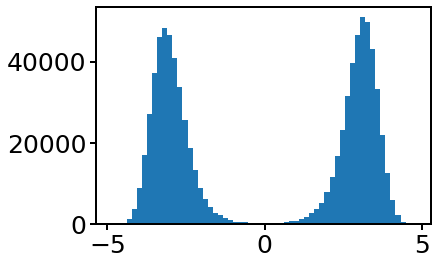

In [1065]:
plt.hist(data, bins=60)
#plt.yscale("log")
plt.show()

# Nonequilibrium Density estimation 

In [1377]:
# construct a NN non-equilibrium flow model 
from torch import nn

nlr = nn.SELU()

# initial model: a NN 
class noneqharm_control(torch.nn.Module):
    def __init__(self, device, tau=100, k_0=1.0):
        super(noneqharm_control, self).__init__()
        self.tau = tau
        self.k_0 = k_0
        self.device = device
        self.net = nn.Sequential(
                                nn.Linear(1, 32), 
                                nlr,
                                nn.Linear(32, 64),
                                nlr,  
                                nn.Linear(64, 32),
                                nlr,
                                nn.Linear(32, 16),
                                nlr,
                                nn.Linear(16, 1)
                               )
        
    def E(self, x):
        return self.net(x) #- self.net(torch.Tensor([0.0]).to(self.device))
    
    def control(self, t): 
        return 1 - (1/self.tau) * t 
    
    def forward(self, x, t):
        #print(self.control(t))
        H = 0.5 * self.k_0 * self.control(t) * x ** 2 + (1 - self.control(t)) * self.E(x)#self.net(x) 
        
#        H = 0.5 * self.k_0 * self.control(t)[:, None] * x ** 2 + 0.5 * 0.1  * (1 - self.control(t)) * x ** 2
#         print(self.net(x).shape)
#         print( (0.5 * self.k_0 * self.control(t) * x ** 2).shape ) 
#         print(self.control(t).shape)
#        print( self.net(x).shape, (x**2).shape) 
        return H

In [1647]:
DEVICE = 0
num_chains = 3
tau = 1
dt = 0.1
t_len = int( tau / dt )

In [1648]:
h = noneqharm_control(tau=tau, device=DEVICE, k_0=0.25).to(DEVICE)

f_x = NHODE(h, 
            torch.Tensor([1.0]), 
            ttime=50.0, 
            num_chains=num_chains, 
            device=DEVICE,
            target_momentum=1.0,
            time_dependent=True,
            dim=1).to(DEVICE)

In [1649]:
#optimizer = torch.optim.SGD(trainable_params, lr=1e-3)
optimizer = torch.optim.Adam(list( h.parameters() ), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

In [1650]:
# maximum likelihood training 

/home/wwj/anaconda3/envs/nff/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/wwj/anaconda3/envs/nff/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


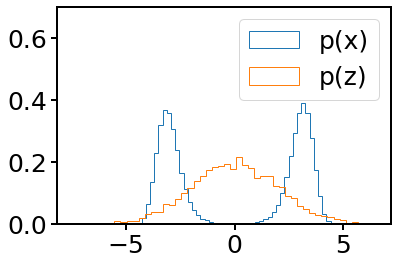

In [1651]:
#plt.hist(x[0, :, 1].detach().cpu().numpy())
#plt.hist(x[-1, :, 1].detach().cpu().numpy(), alpha=0.3, normed=True, bins=100)
plt.hist(data, bins=50, normed=True,label='p(x)',
         histtype='step')
plt.hist(torch.empty(B, 1).normal_(mean=0,std=2).detach().cpu().numpy(),
         bins=50, normed=True, #alpha=0.2, 
         label='p(z)', histtype='step')  
plt.legend()
plt.ylim(0,0.7)
plt.show()

In [1652]:
x.shape

torch.Size([10, 4096, 5])

In [1653]:
from sklearn.utils import shuffle
B = 4096

samples = torch.Tensor( shuffle(data.reshape(-1, B, 1)) ).to(DEVICE)
batch = samples[0]

In [1654]:
# learning rate schdular 
#f_x.model.tau=2

0.11410428583621979
1.018341913819313 1


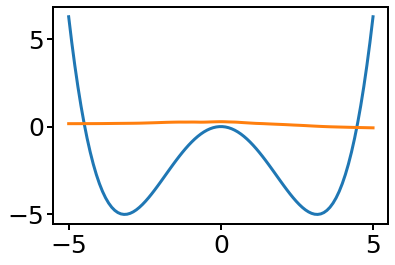

0.054359130561351776
0.909280352294445 1.005


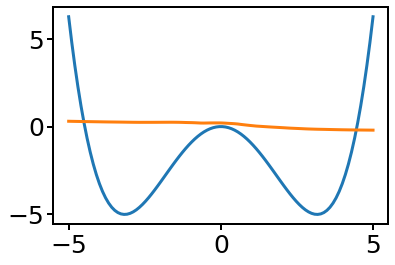

0.026763515546917915
0.7746546436101198 1.0099999999999998


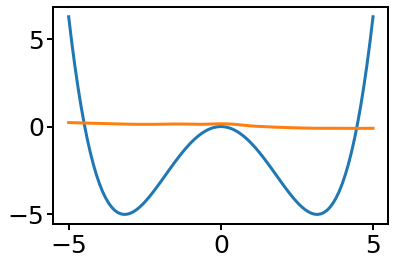

0.006490945816040039
0.9459511637687683 1.0149999999999997


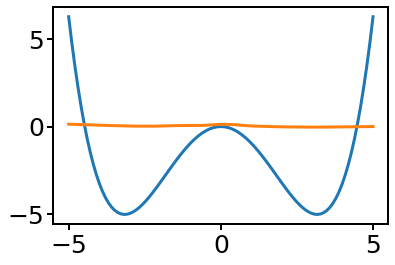

-0.008318470790982246
0.910385562106967 1.0199999999999996


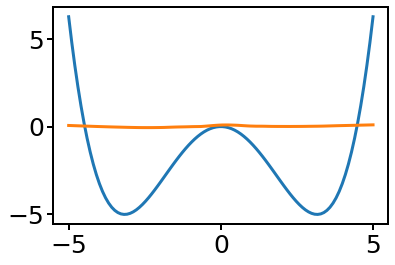

-0.016778381541371346
1.0032084863632917 1.0249999999999995


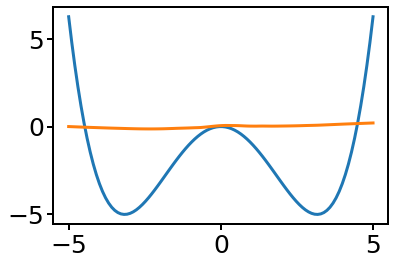

-0.03495107591152191
1.1623689085245132 1.0299999999999994


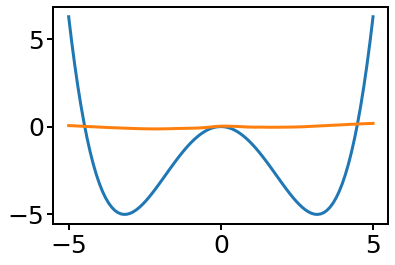

-0.055660270154476166
0.9396866336464882 1.0349999999999993


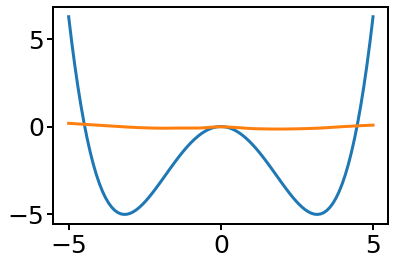

-0.0762581154704094
0.8397362902760506 1.0399999999999991


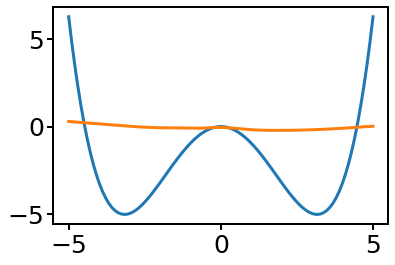

-0.08380421996116638
0.791809469461441 1.044999999999999


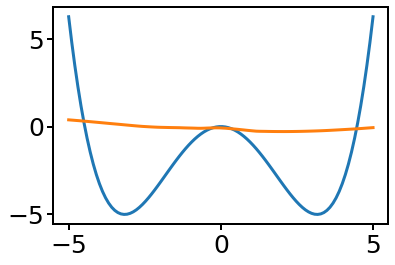

-0.0993134155869484
0.7423890456557274 1.049999999999999


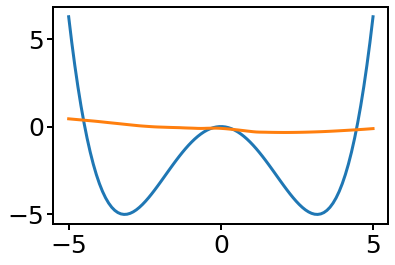

-0.11063693463802338
0.7208444625139236 1.0549999999999988


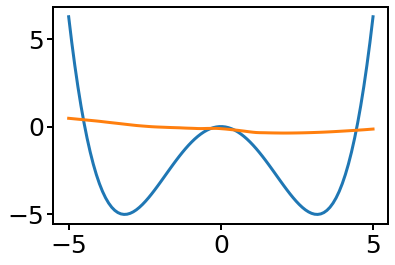

-0.12455210089683533
0.8058743178844452 1.0599999999999987


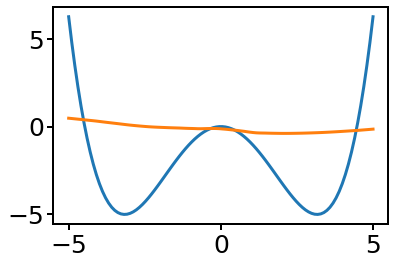

-0.1492210030555725
0.695124089717865 1.0649999999999986


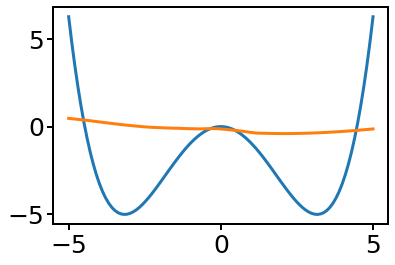

-0.1577560007572174
0.8489250838756561 1.0699999999999985


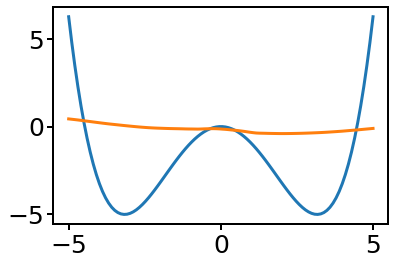

-0.17233221232891083
0.7110367566347122 1.0749999999999984


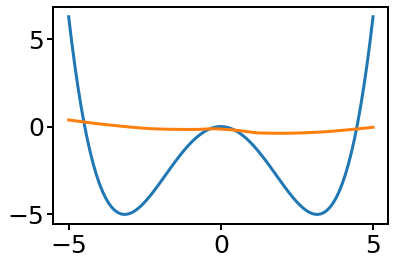

-0.1828557699918747
0.6345423012971878 1.0799999999999983


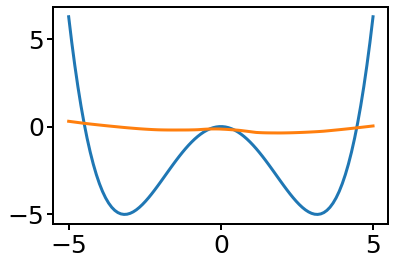

-0.18690189719200134
0.6861713826656342 1.0849999999999982


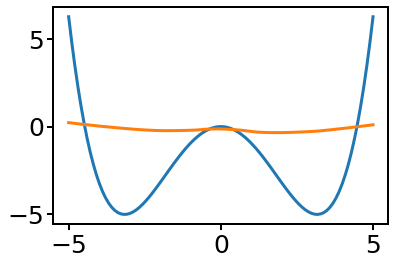

-0.20300880074501038
0.7419576942920685 1.089999999999998


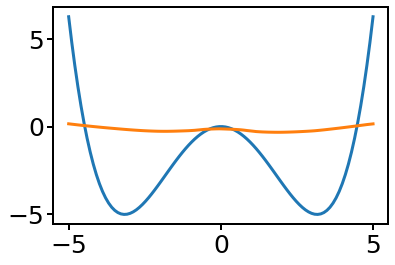

-0.20378310978412628
0.6868219822645187 1.094999999999998


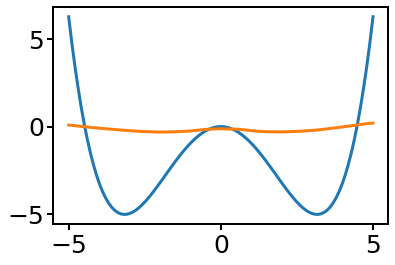

-0.21693459153175354
0.5881989896297455 1.0999999999999979


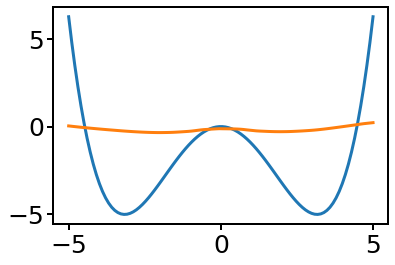

-0.240550696849823
0.6248653531074524 1.1049999999999978


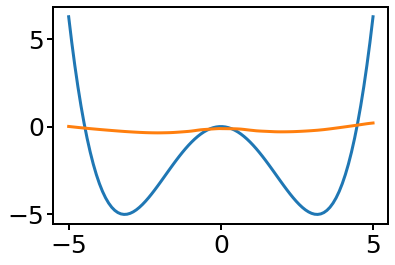

-0.27281272411346436
0.6286507844924927 1.1099999999999977


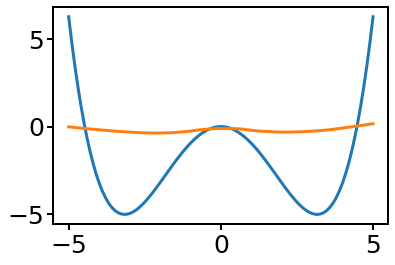

-0.2907838821411133
0.624498724937439 1.1149999999999975


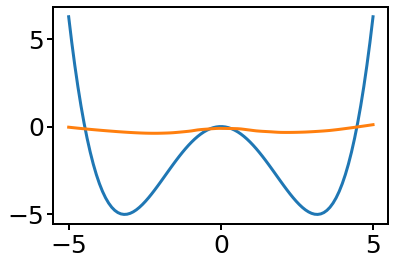

-0.3186699151992798
0.550400972366333 1.1199999999999974


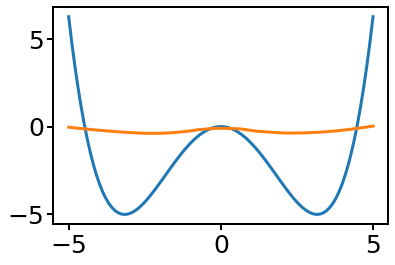

-0.3471716046333313
0.5016339421272278 1.1249999999999973


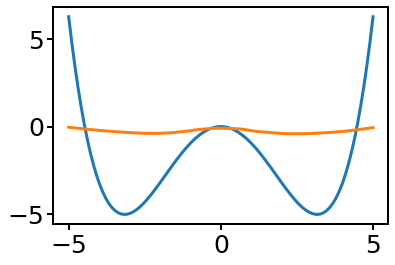

-0.3747997581958771
0.547129362821579 1.1299999999999972


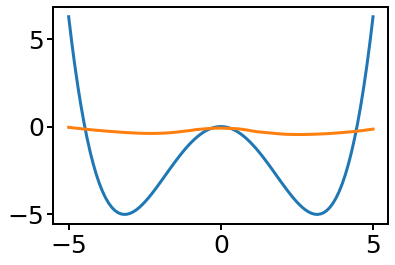

-0.40312349796295166
0.4656297564506531 1.1349999999999971


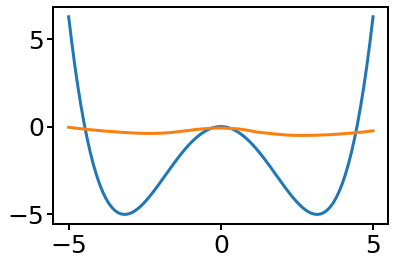

-0.4377478361129761
0.44243210554122925 1.139999999999997


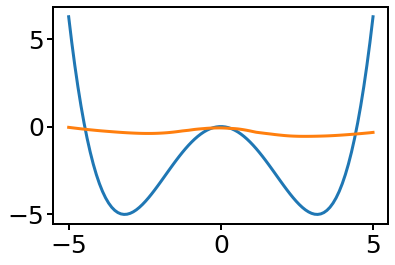

-0.4689980149269104
0.4576870799064636 1.144999999999997


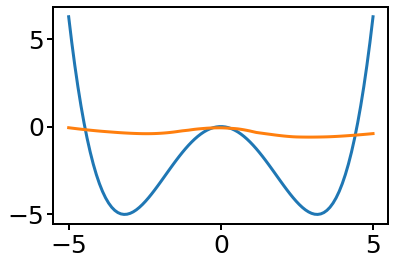

-0.5026519298553467
0.4373657703399658 1.1499999999999968


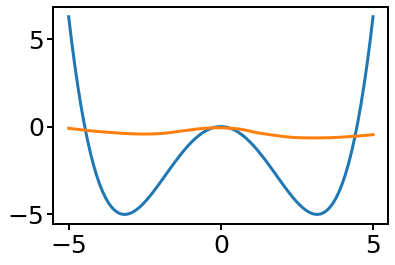

-0.5416704416275024
0.41449785232543945 1.1549999999999967


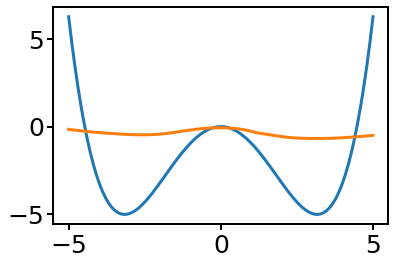

-0.5855101943016052
0.42493218183517456 1.1599999999999966


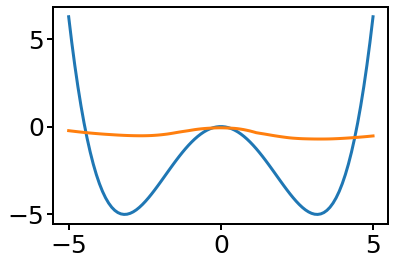

-0.632568359375
0.4581831693649292 1.1649999999999965


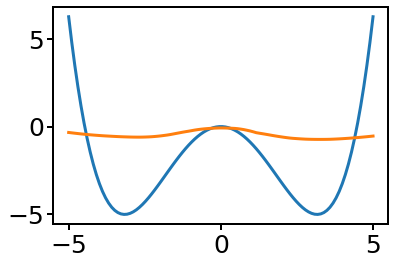

-0.6881085634231567
0.292083740234375 1.1699999999999964


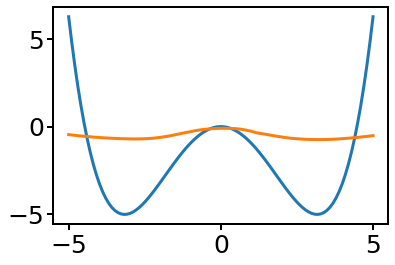

-0.7482914924621582
0.33885788917541504 1.1749999999999963


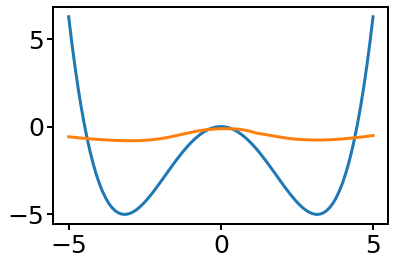

-0.8110724687576294
0.26782941818237305 1.1799999999999962


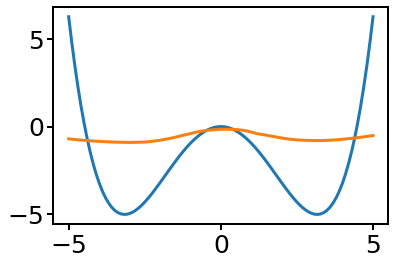

-0.8840960264205933
0.24305450916290283 1.184999999999996


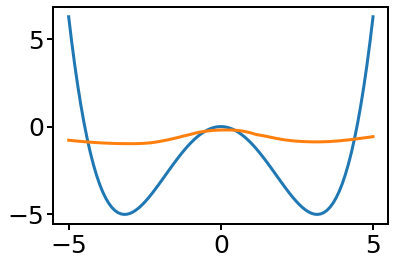

-0.96449875831604
0.2257150411605835 1.189999999999996


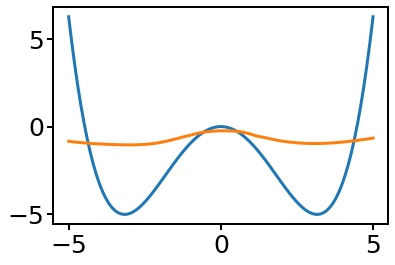

-1.0474050045013428
0.271726131439209 1.1949999999999958


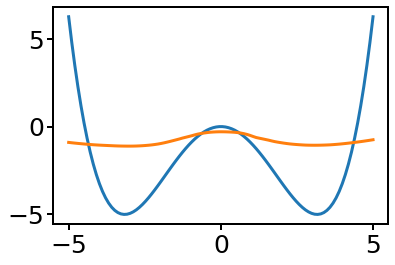

-1.1346807479858398
0.1586226224899292 1.1999999999999957


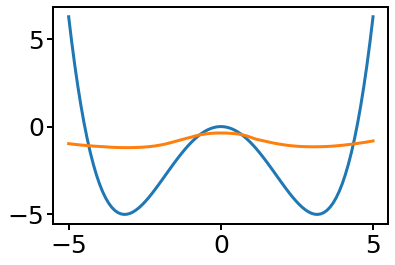

-1.2255759239196777
0.11849117279052734 1.2049999999999956


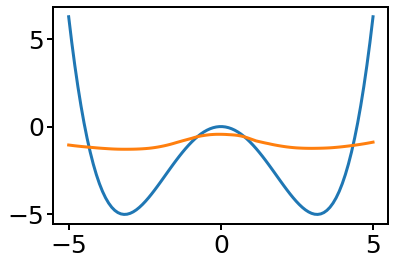

-1.3218631744384766
0.088997483253479 1.2099999999999955


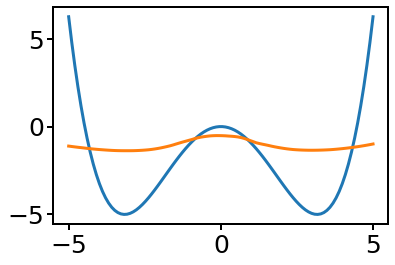

-1.4230680465698242
0.047009944915771484 1.2149999999999954


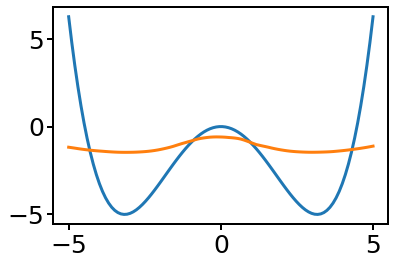

-1.5276451110839844
0.08461344242095947 1.2199999999999953


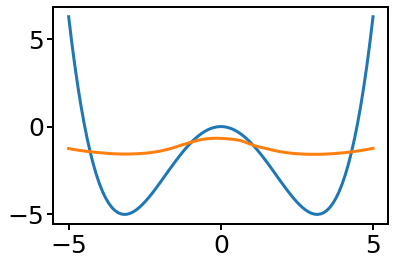

-1.6396405696868896
-0.04769468307495117 1.2249999999999952


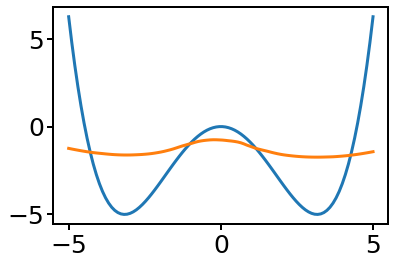

-1.7461252212524414
-0.033980727195739746 1.229999999999995


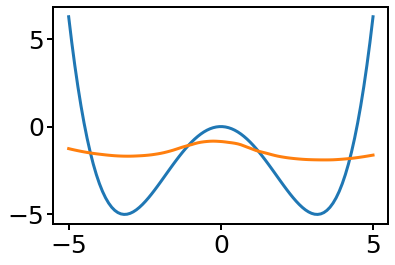

-1.8581500053405762
-0.1594620943069458 1.234999999999995


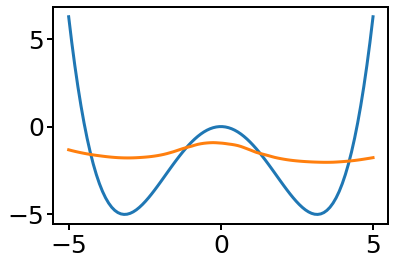

-1.9802325963974
-0.1919877529144287 1.2399999999999949


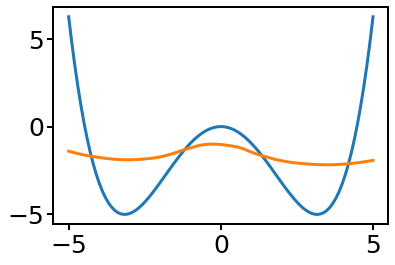

-2.0985844135284424
-0.2178354263305664 1.2449999999999948


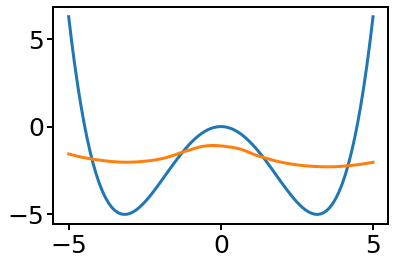

-2.2256863117218018
-0.26225554943084717 1.2499999999999947


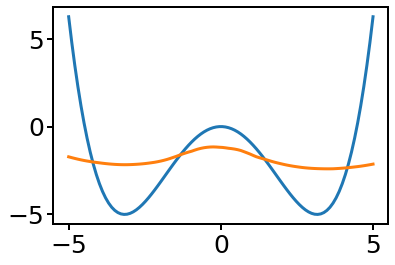

-2.36175274848938
-0.3538799285888672 1.2549999999999946


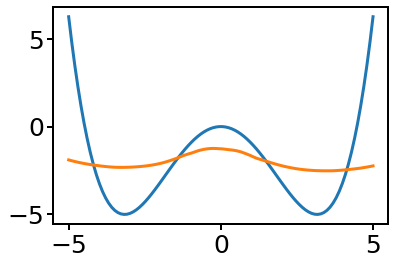

-2.4885191917419434
-0.3824462890625 1.2599999999999945


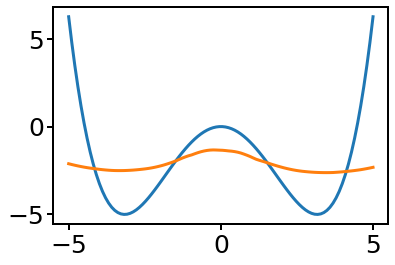

-2.639613151550293
-0.45890259742736816 1.2649999999999944


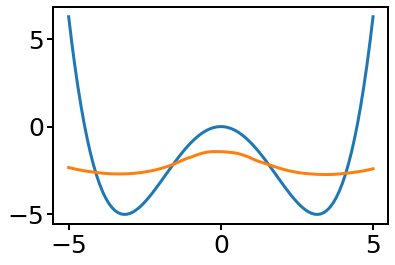

-2.7880606651306152
-0.5275321006774902 1.2699999999999942


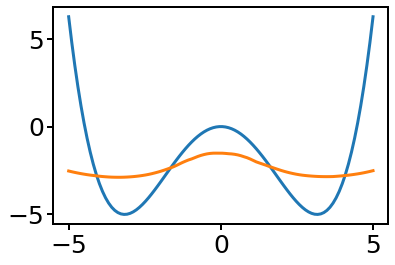

-2.93643856048584
-0.6132636070251465 1.2749999999999941


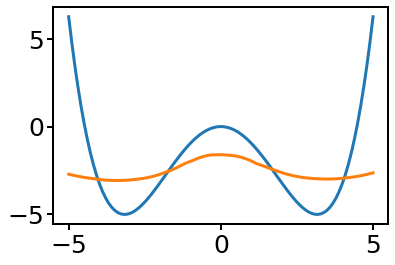

-3.1016595363616943
-0.6530964374542236 1.279999999999994


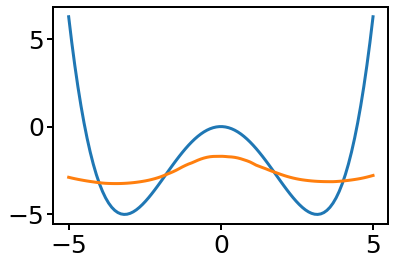

-3.2508673667907715
-0.6910407543182373 1.284999999999994


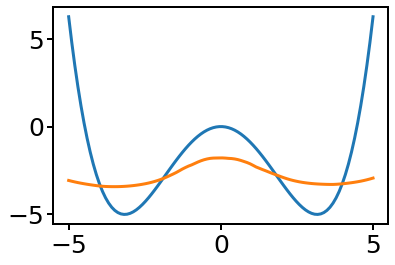

-3.40958833694458
-0.7648780345916748 1.2899999999999938


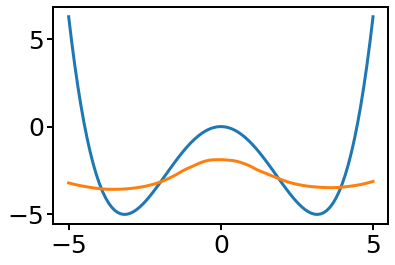

-3.5739660263061523
-0.8559763431549072 1.2949999999999937


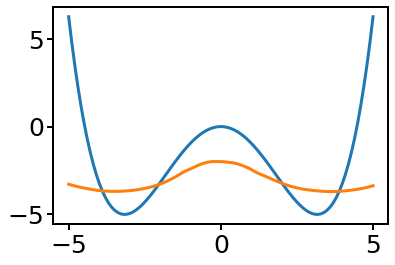

-3.7496449947357178
-0.9313361644744873 1.2999999999999936


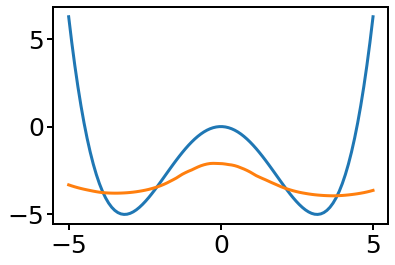

-3.904036283493042
-0.949540376663208 1.3049999999999935


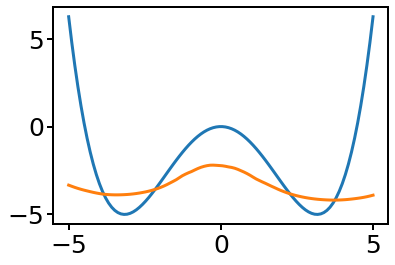

-4.076251983642578
-1.0248446464538574 1.3099999999999934


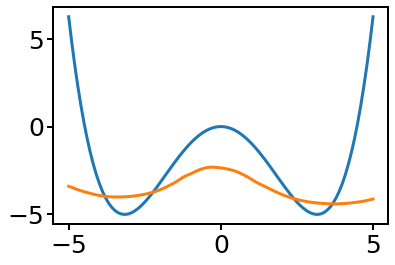

-4.248331546783447
-1.1207447052001953 1.3149999999999933


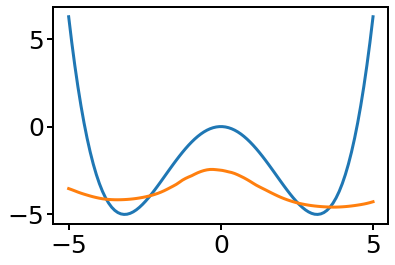

-4.436604022979736
-1.2734198570251465 1.3199999999999932


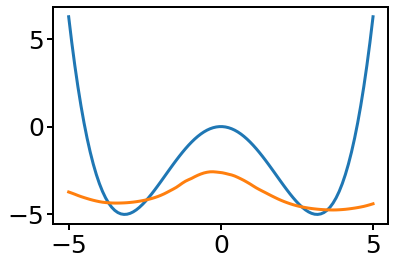

-4.6030426025390625
-1.2762699127197266 1.324999999999993


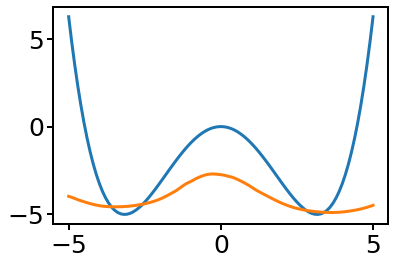

-4.775764465332031
-1.4133968353271484 1.329999999999993


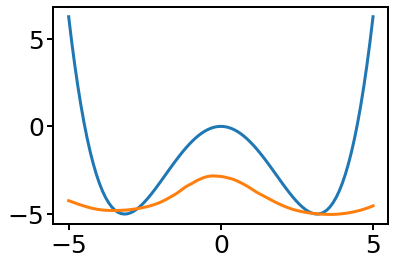

-4.9641947746276855
-1.4652371406555176 1.3349999999999929


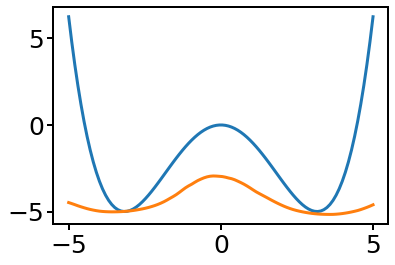

-5.133666515350342
-1.5447425842285156 1.3399999999999928


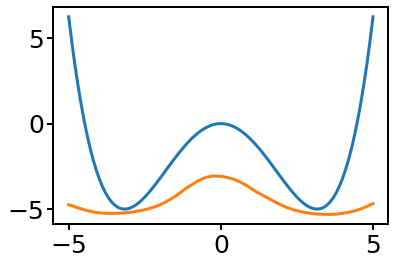

-5.326642036437988
-1.6153442859649658 1.3449999999999926


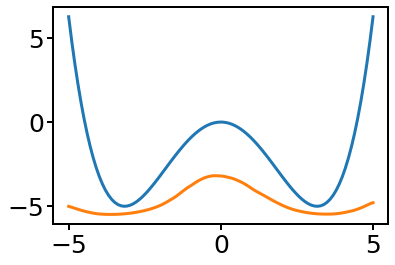

-5.513309478759766
-1.6889803409576416 1.3499999999999925


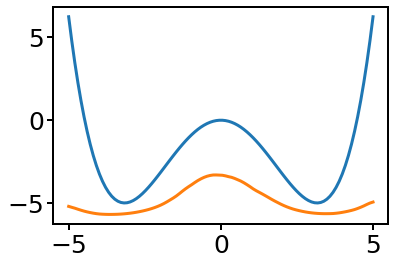

-5.719384670257568
-1.8311998844146729 1.3549999999999924


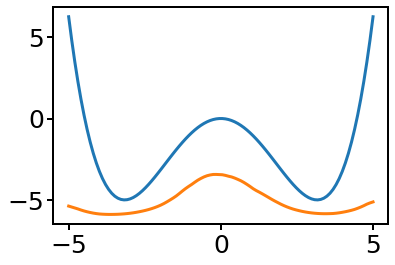

-5.922520160675049
-1.8969621658325195 1.3599999999999923


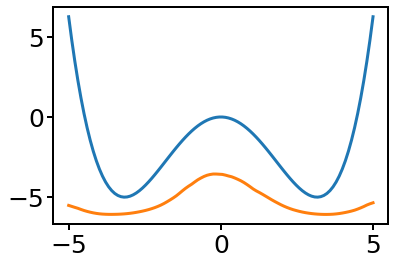

-6.146721839904785
-1.9774131774902344 1.3649999999999922


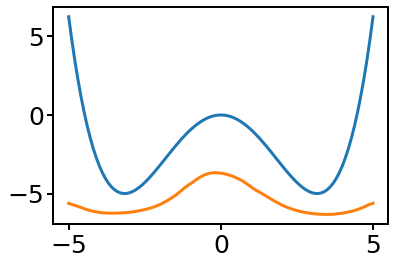

-6.346770763397217
-2.11531400680542 1.3699999999999921


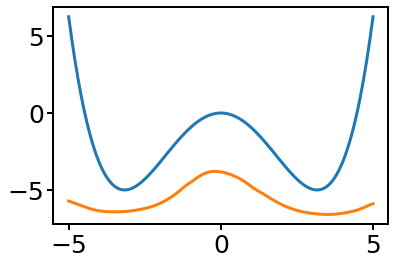

-6.578457832336426
-2.2525057792663574 1.374999999999992


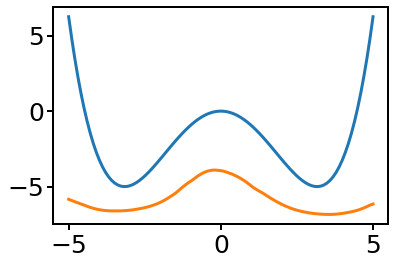

-6.803764820098877
-2.337459087371826 1.379999999999992


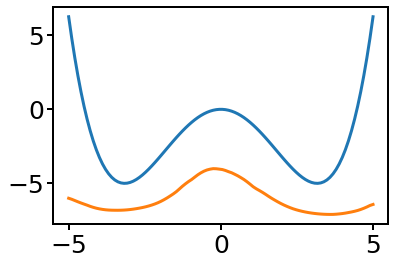

-7.017413139343262
-2.4316577911376953 1.3849999999999918


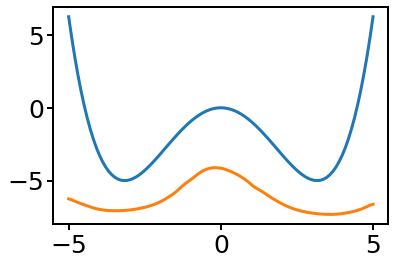

-7.2515058517456055
-2.4985437393188477 1.3899999999999917


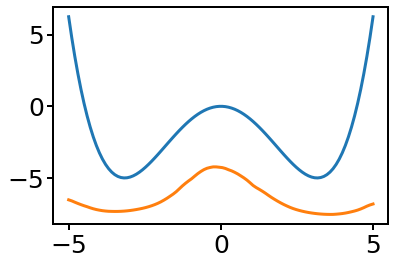

-7.5021491050720215
-2.648179054260254 1.3949999999999916


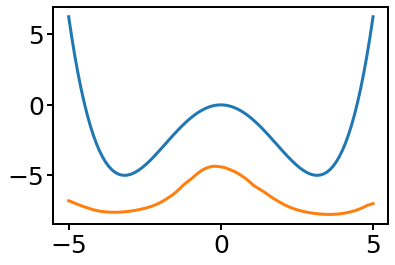

-7.737051010131836
-2.767829418182373 1.3999999999999915


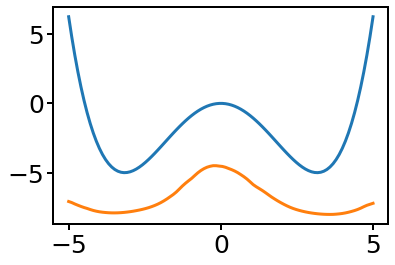

-8.01064682006836
-2.898149013519287 1.4049999999999914


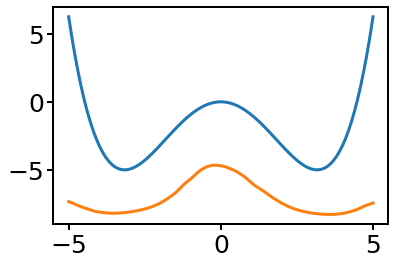

-8.282705307006836
-3.0197105407714844 1.4099999999999913


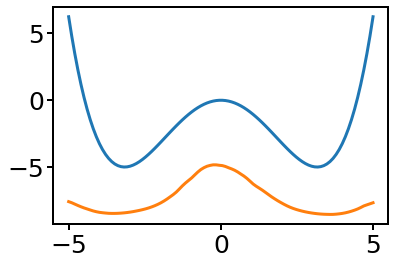

-8.567026138305664
-3.146023750305176 1.4149999999999912


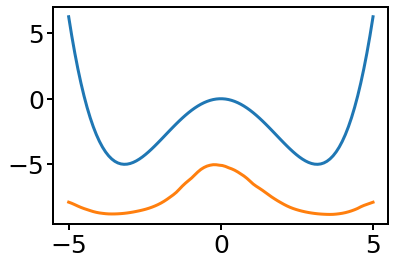

-8.87560749053955
-3.2985119819641113 1.419999999999991


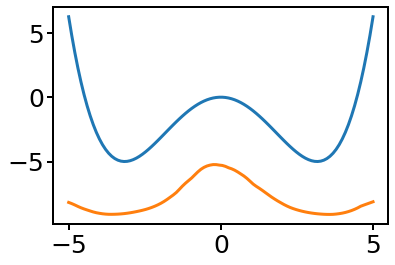

-9.18940258026123
-3.4345245361328125 1.424999999999991


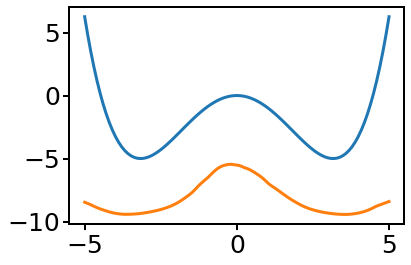

-9.51919937133789
-3.5896549224853516 1.4299999999999908


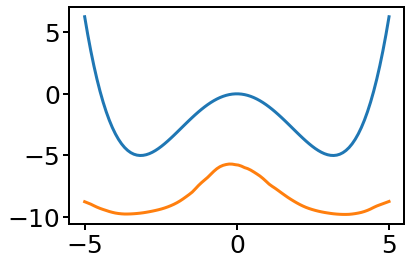

-9.844686508178711
-3.7669548988342285 1.4349999999999907


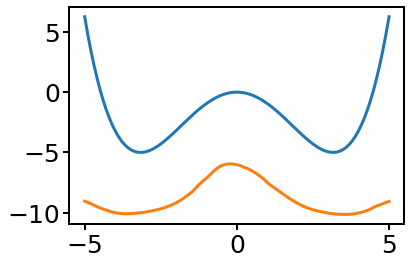

-10.224481582641602
-3.9547061920166016 1.4399999999999906


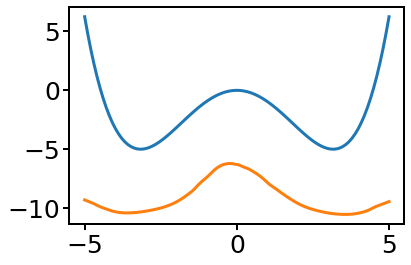

-10.569963455200195
-4.070710182189941 1.4449999999999905


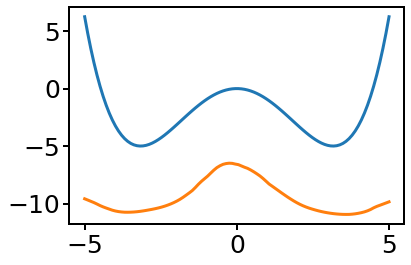

-10.9833984375
-4.285268783569336 1.4499999999999904


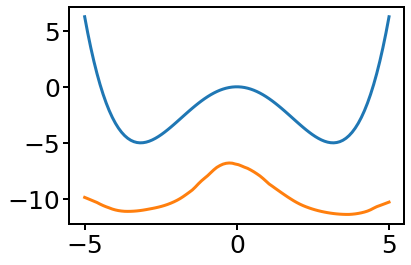

-11.364391326904297
-4.422629356384277 1.4549999999999903


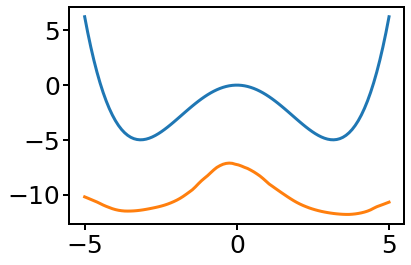

-11.781682968139648
-4.663163661956787 1.4599999999999902


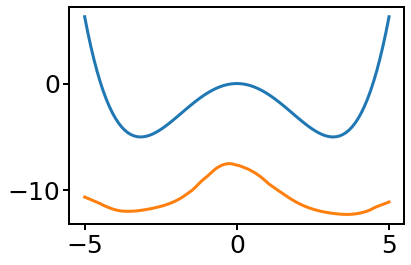

-12.276346206665039
-4.903613567352295 1.46499999999999


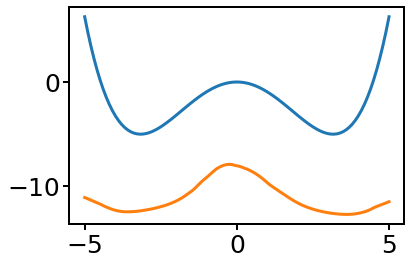

-12.745315551757812
-5.107762813568115 1.46999999999999


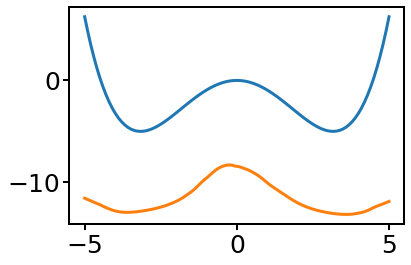

-13.235071182250977
-5.294060230255127 1.4749999999999899


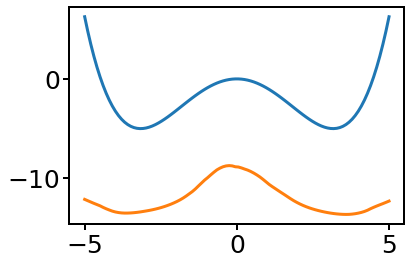

-13.78051471710205
-5.570217132568359 1.4799999999999898


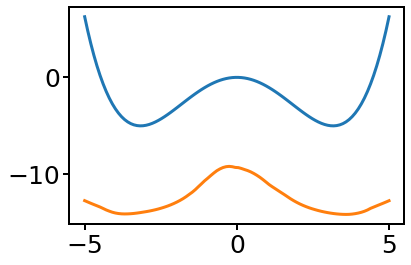

-14.334794044494629
-5.857394218444824 1.4849999999999897


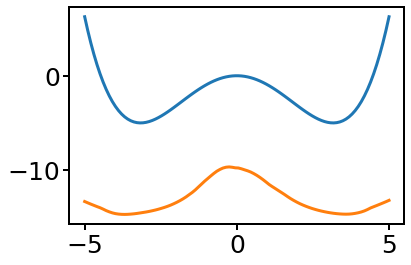

-14.896207809448242
-6.0803985595703125 1.4899999999999896


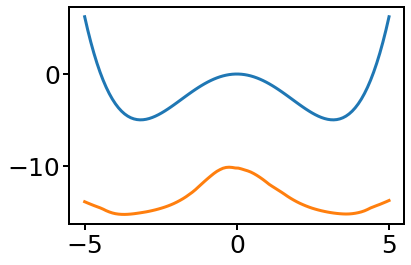

-15.526571273803711
-6.384042739868164 1.4949999999999894


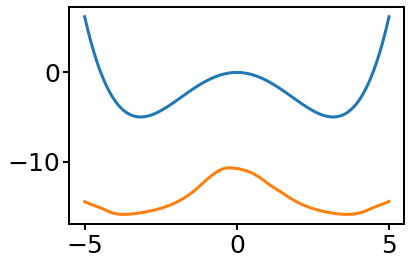

-16.1752986907959
-6.664155006408691 1.4999999999999893


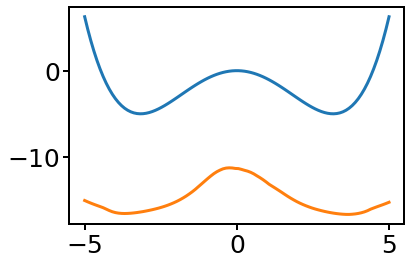

-16.893638610839844
-6.996786117553711 1.5049999999999892


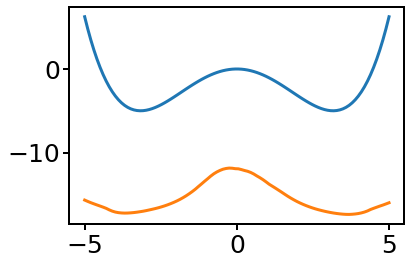

-17.61956024169922
-7.361088752746582 1.5099999999999891


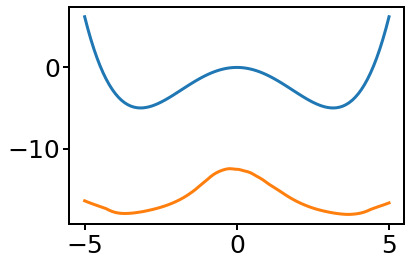

-18.375391006469727
-7.70811653137207 1.514999999999989


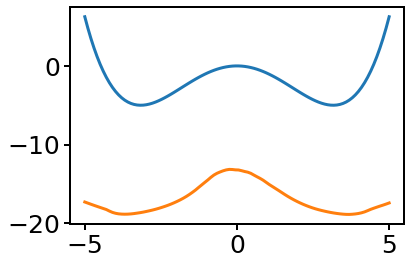

-19.173215866088867
-8.053168296813965 1.519999999999989


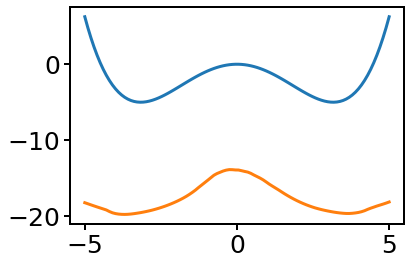

-20.033756256103516
-8.442659378051758 1.5249999999999888


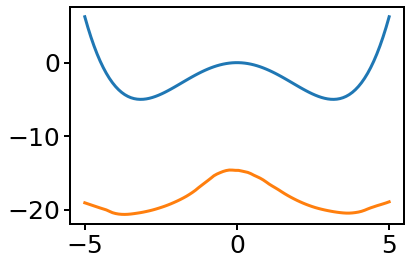

-20.955902099609375
-8.896476745605469 1.5299999999999887


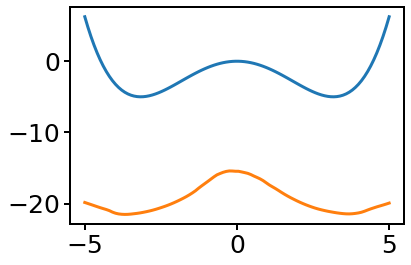

-21.926605224609375
-9.348029136657715 1.5349999999999886


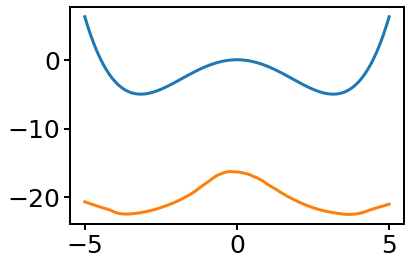

-22.88065528869629
-9.73892593383789 1.5399999999999885


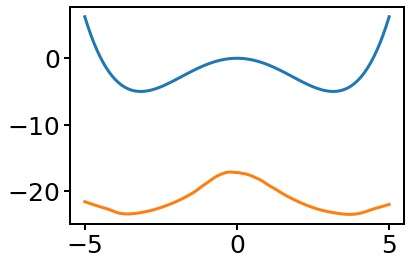

-23.968971252441406
-10.276358604431152 1.5449999999999884


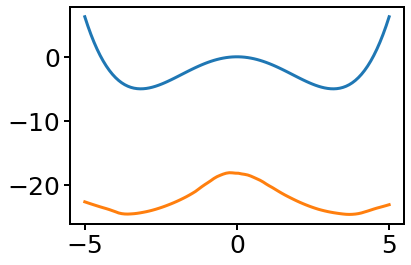

-25.051841735839844
-10.736998558044434 1.5499999999999883


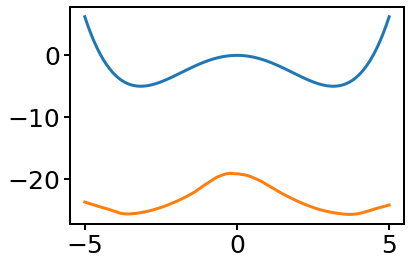

-26.273765563964844
-11.360128402709961 1.5549999999999882


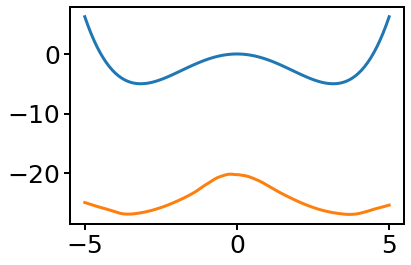

-27.459840774536133
-11.927582740783691 1.559999999999988


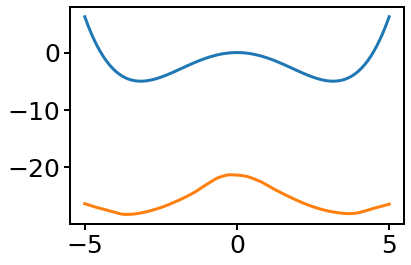

-28.80980682373047
-12.55984115600586 1.564999999999988


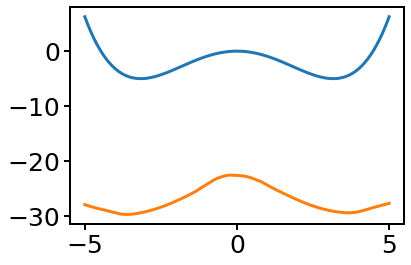

-30.235244750976562
-13.202043533325195 1.5699999999999878


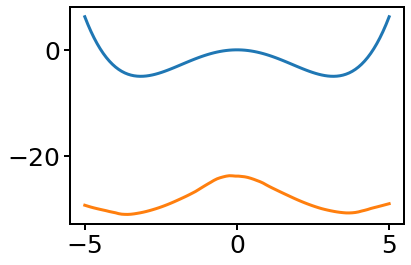

-31.64565086364746
-13.88034439086914 1.5749999999999877


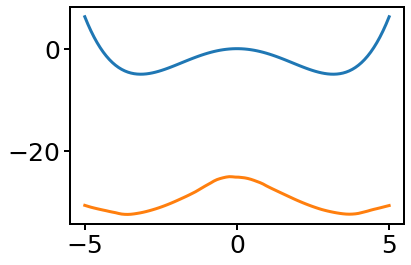

-33.124786376953125
-14.626663208007812 1.5799999999999876


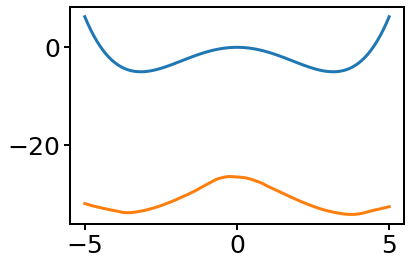

-34.77440643310547
-15.372682571411133 1.5849999999999875


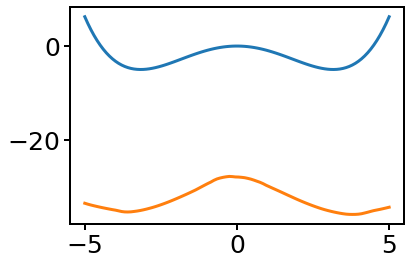

-36.31707763671875
-16.024059295654297 1.5899999999999874


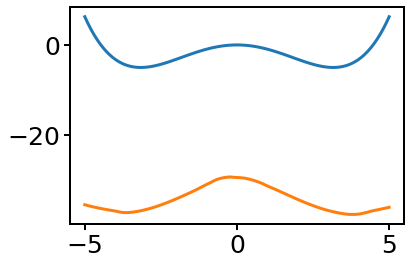

-38.139610290527344
-16.907459259033203 1.5949999999999873


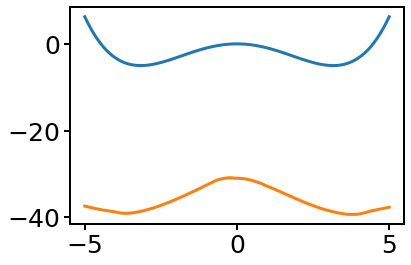

-39.94383239746094
-17.728010177612305 1.5999999999999872


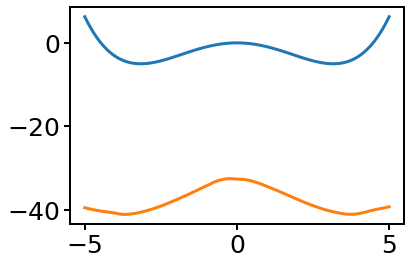

-41.68220520019531
-18.513099670410156 1.604999999999987


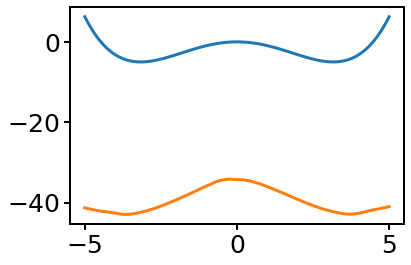

-43.584747314453125
-19.47564697265625 1.609999999999987


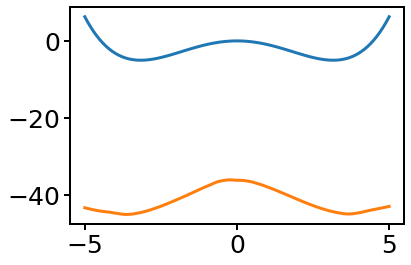

-45.71826171875
-20.57647132873535 1.614999999999987


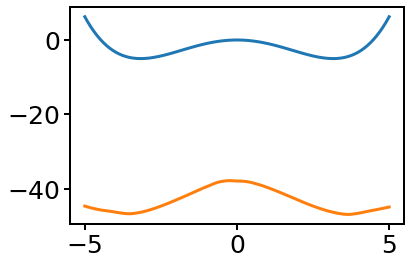

-47.83644104003906
-21.63433837890625 1.6199999999999868


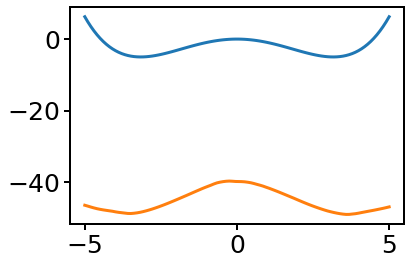

-49.931434631347656
-22.61516571044922 1.6249999999999867


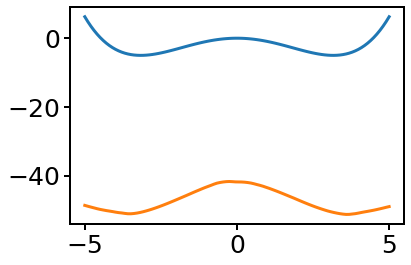

-52.39329528808594
-23.88388442993164 1.6299999999999866


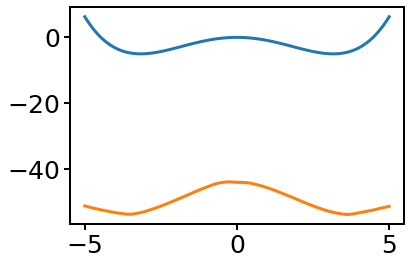

-54.62373352050781
-24.785388946533203 1.6349999999999865


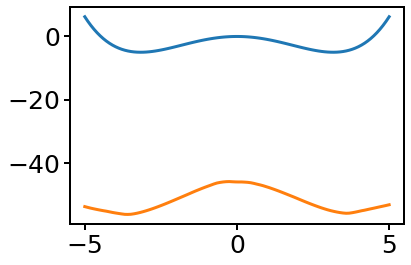

-57.30877685546875
-26.216365814208984 1.6399999999999864


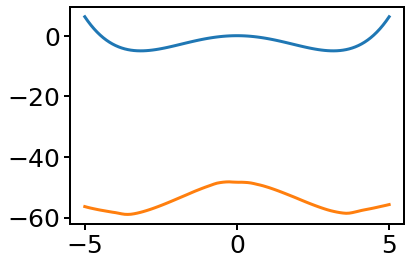

-59.734779357910156
-27.379901885986328 1.6449999999999863


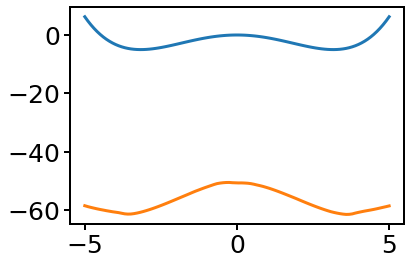

-62.46415710449219
-28.65575408935547 1.6499999999999861


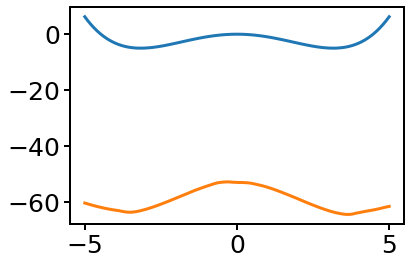

-65.36555480957031
-30.149532318115234 1.654999999999986


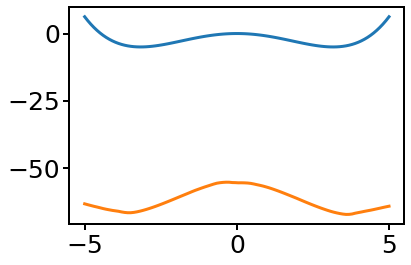

-68.18811798095703
-31.481128692626953 1.659999999999986


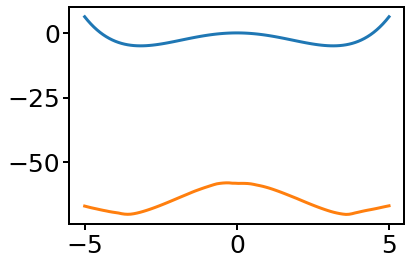

-71.42439270019531
-33.17535400390625 1.6649999999999858


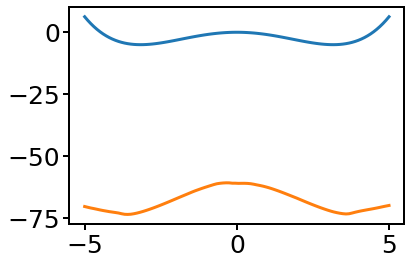

-74.41642761230469
-34.48723220825195 1.6699999999999857


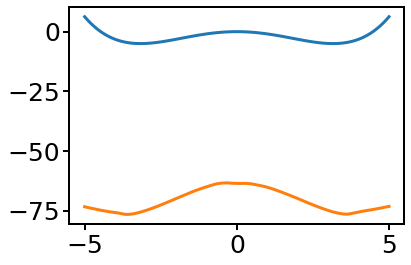

-77.89007568359375
-36.281349182128906 1.6749999999999856


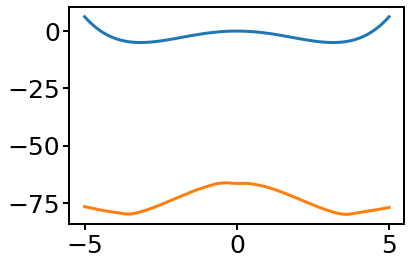

-81.2418441772461
-37.84840774536133 1.6799999999999855


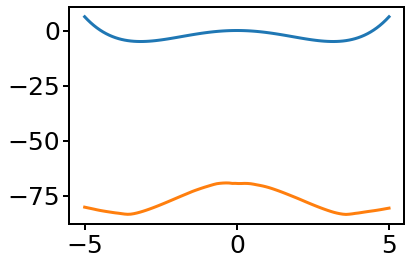

-84.76931762695312
-39.62303161621094 1.6849999999999854


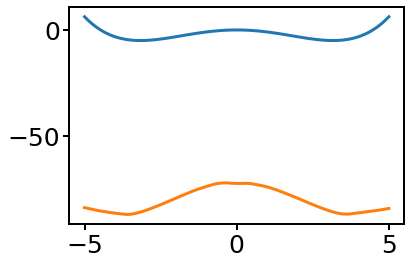

-88.32292175292969
-41.3233642578125 1.6899999999999853


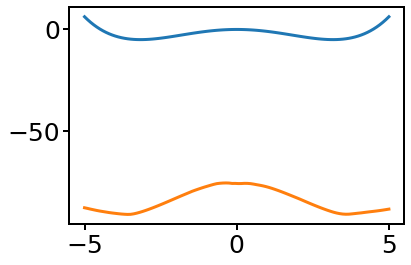

-92.0218505859375
-43.12851333618164 1.6949999999999852


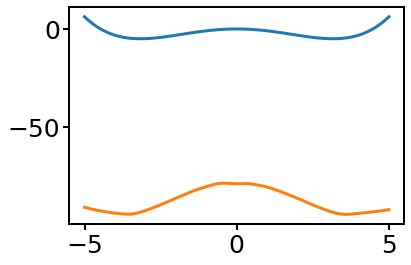

-96.09661865234375
-45.281578063964844 1.699999999999985


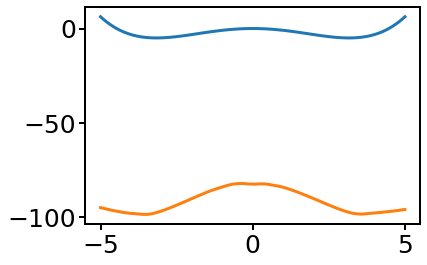

-100.0771484375
-47.21963882446289 1.704999999999985


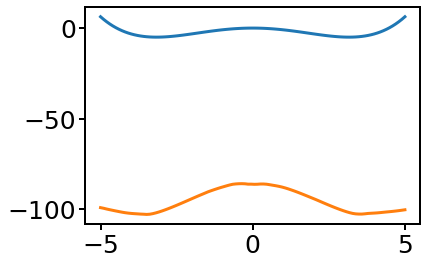

-104.07046508789062
-49.129478454589844 1.7099999999999849


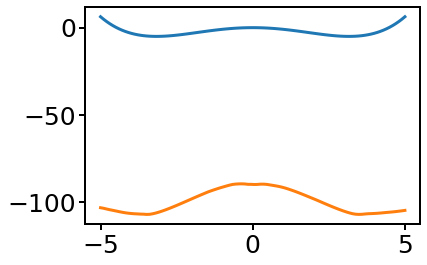

-108.73299407958984
-51.667354583740234 1.7149999999999848


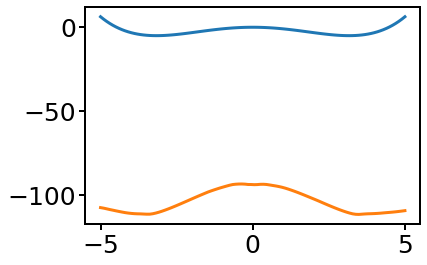

-113.44944763183594
-54.08092498779297 1.7199999999999847


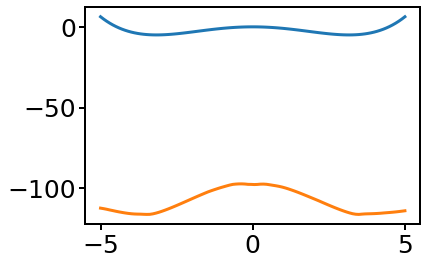

-118.31817626953125
-56.48326873779297 1.7249999999999845


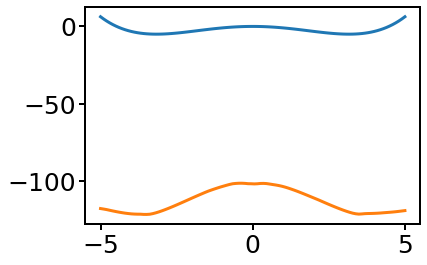

-123.47381591796875
-58.997894287109375 1.7299999999999844


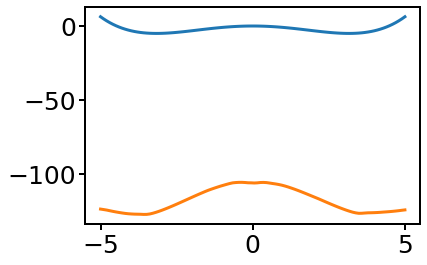

-128.38717651367188
-61.30812072753906 1.7349999999999843


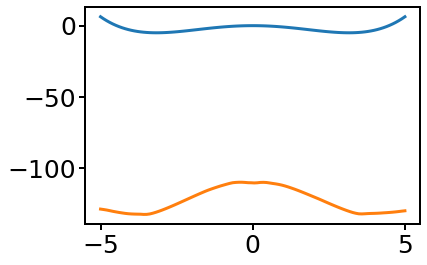

-133.81663513183594
-64.23194122314453 1.7399999999999842


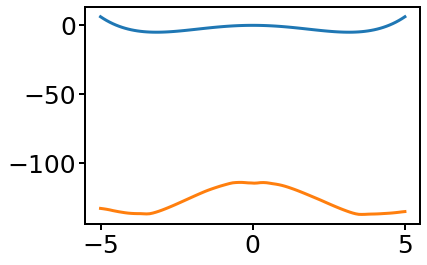

-138.68829345703125
-66.63921356201172 1.7449999999999841


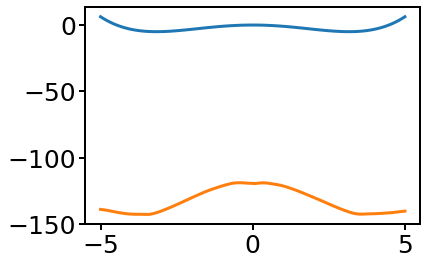

-144.437255859375
-69.84194946289062 1.749999999999984


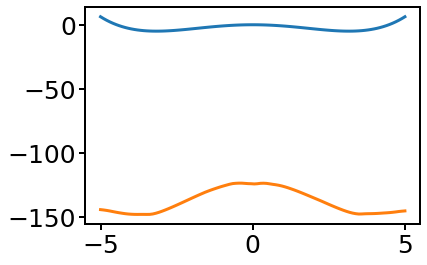

-149.69863891601562
-72.31715393066406 1.754999999999984


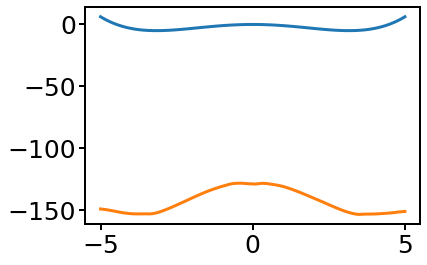

-155.61338806152344
-75.38128662109375 1.7599999999999838


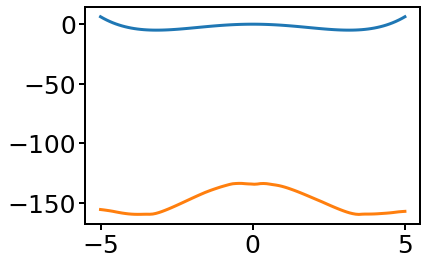

-161.71298217773438
inf 1.7649999999999837


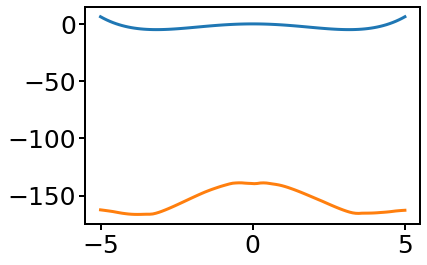

-169.33157348632812
inf 1.7699999999999836


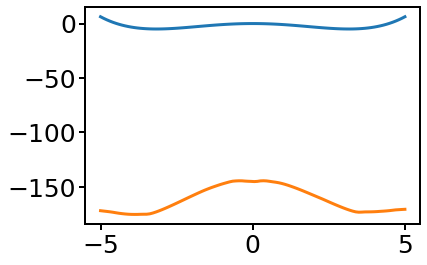

nan
nan 1.7749999999999835


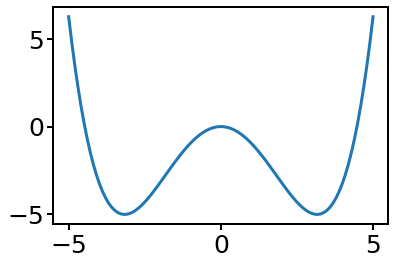

nan
nan 1.7799999999999834


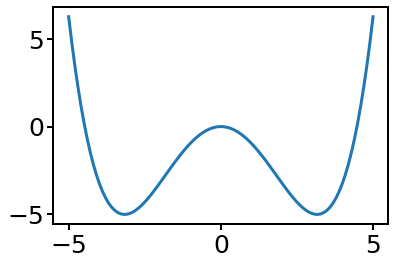

nan
nan 1.7849999999999833


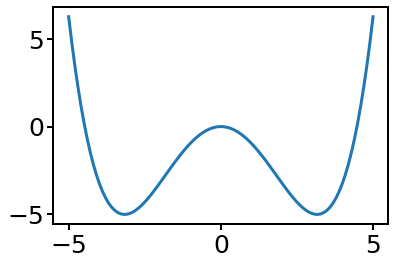

nan
nan 1.7899999999999832


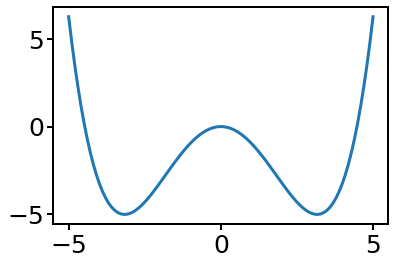

nan
nan 1.794999999999983


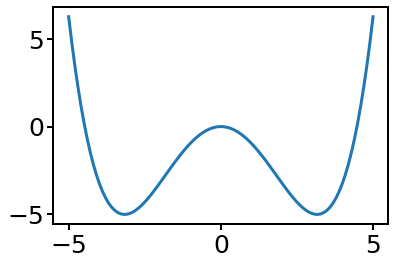

nan
nan 1.799999999999983


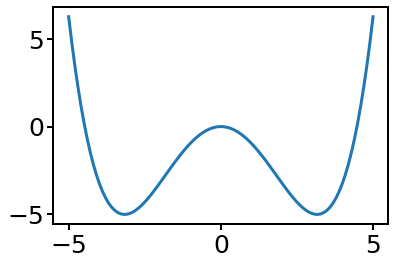

nan
nan 1.8049999999999828


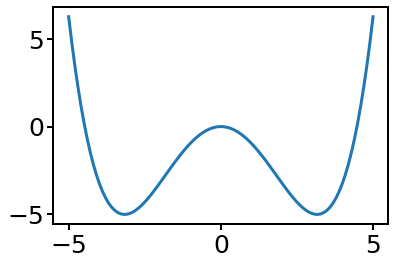

nan
nan 1.8099999999999827


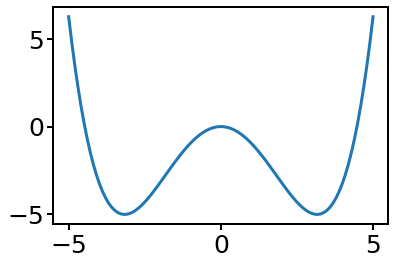

nan
nan 1.8149999999999826


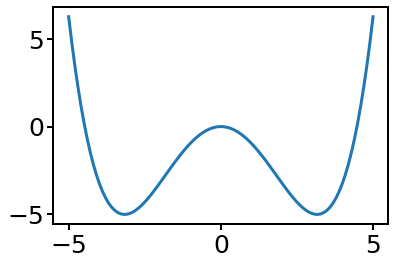

nan
nan 1.8199999999999825


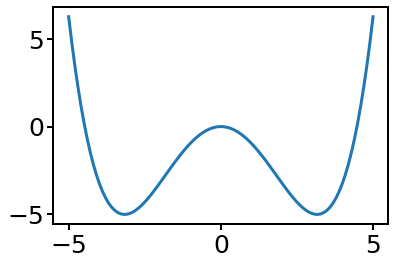

nan
nan 1.8249999999999824


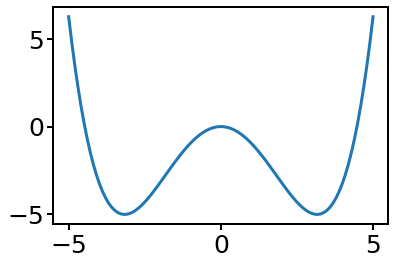

nan
nan 1.8299999999999823


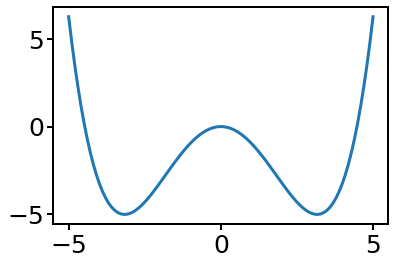

nan
nan 1.8349999999999822


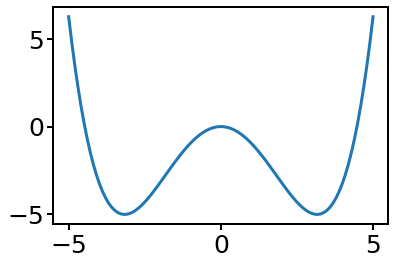

nan
nan 1.839999999999982


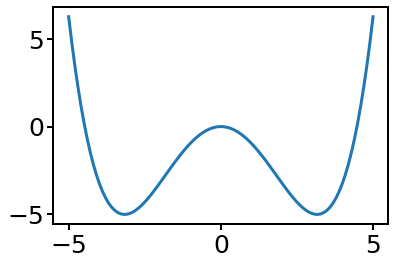

nan
nan 1.844999999999982


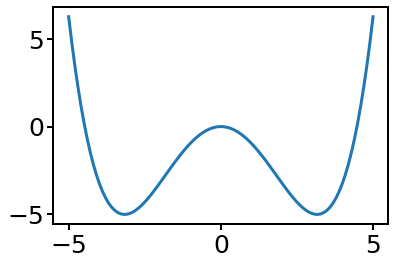

nan
nan 1.8499999999999819


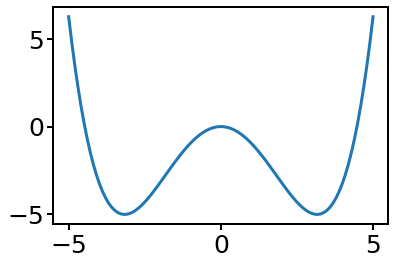

nan
nan 1.8549999999999818


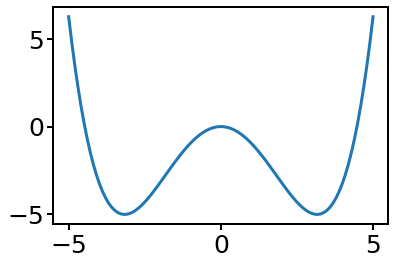

nan
nan 1.8599999999999817


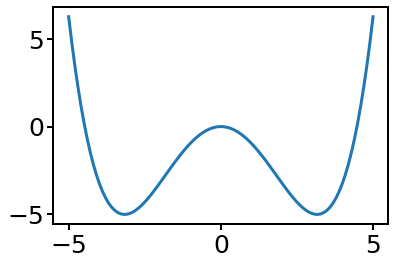

nan
nan 1.8649999999999816


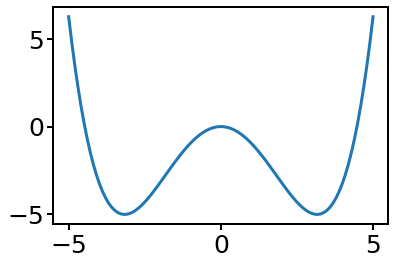

nan
nan 1.8699999999999815


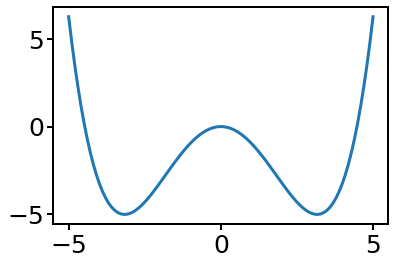

nan
nan 1.8749999999999813


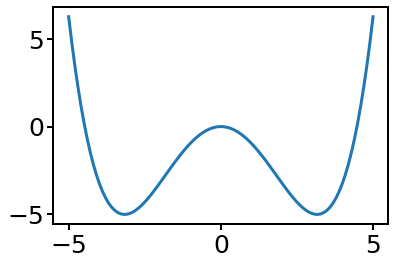

nan
nan 1.8799999999999812


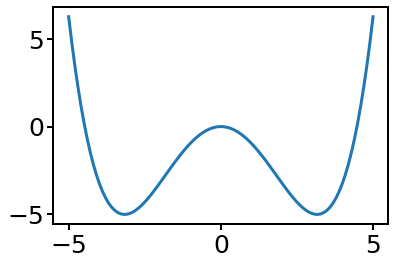

nan
nan 1.8849999999999811


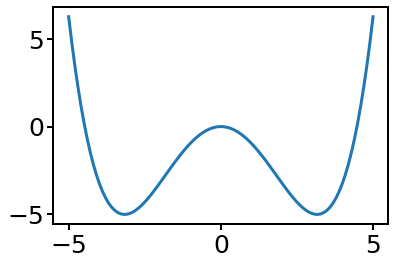

nan
nan 1.889999999999981


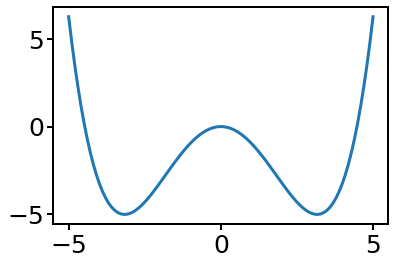

nan
nan 1.894999999999981


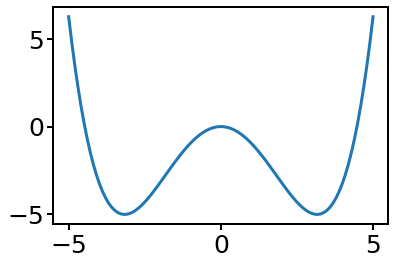

nan
nan 1.8999999999999808


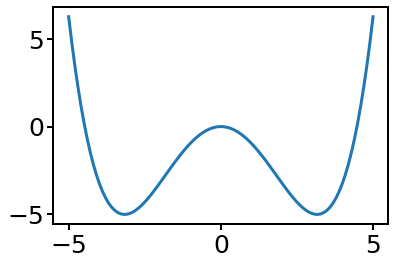

nan
nan 1.9049999999999807


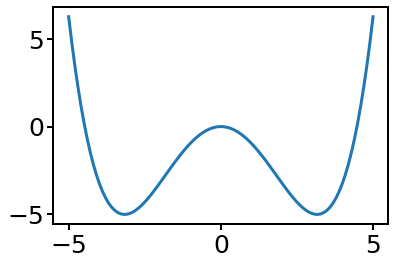

nan
nan 1.9099999999999806


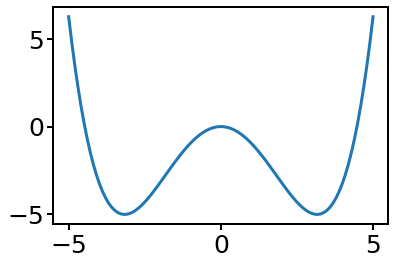

nan
nan 1.9149999999999805


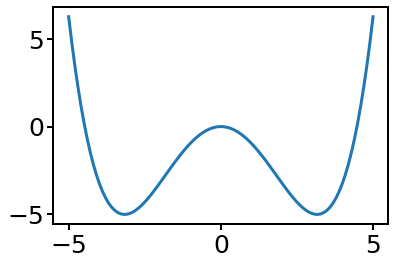

nan
nan 1.9199999999999804


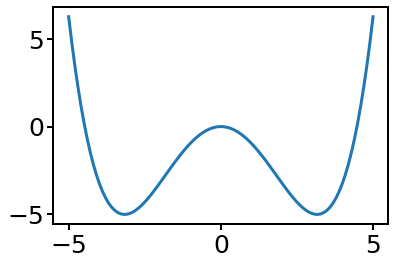

nan
nan 1.9249999999999803


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [1655]:
loss_run = []

for epoch in range(10):
    
    for i, batch in enumerate(samples):

        data_nll = h.E(batch)
        print(data_nll.mean().item())
        
        # sample from normal distribution and deform 
        p_v = torch.empty(B, 3).normal_(mean=0,std=1)
        q = torch.empty(B, 1).normal_(mean=0,std=2) 
        p = torch.empty(B, 1).normal_(mean=0,std=1)
        W = torch.zeros(B, 1).to(DEVICE)
        Q = torch.zeros(B, 1).to(DEVICE)

        pq = torch.cat((p, q, p_v), dim=1).to(DEVICE)
        pq.requires_grad= True

        t = torch.Tensor([dt * i for i in range(t_len)]).to(DEVICE)
        x, W_traj, Q_traj = odeint(f_x, (pq, W, Q), t, method='rk4')
        
        #sample_nll = h.net(x[-1, :, [1]])
        
        logZ = -torch.log( torch.exp(-W_traj[-1].reshape(-1)).mean() )
        # naively match energy 
        #match_energy = (h.E(x[-1, :, [1]]).mean() - data_nll.mean()).pow(2)
        
#         if i <= 50:
#             loss = -logZ + 1.5 * data_nll.mean() #+ match_energy
#         else:
        loss = -logZ + data_nll.mean() #+ 0.1 * (data_nll - 0.0).pow(2).mean()
        
        loss.backward()
        
        loss_run.append([data_nll.mean().item(), -logZ.item()]) 
        
        print(np.array(loss_run[-1]).sum(), f_x.model.tau) 
        
        if f_x.model.tau <= 5 and f_x.model.tau >=1.0:
            f_x.model.tau += 0.005
        
        linsp = torch.linspace(-5.,5.)[:, None]
        plt.plot(linsp, harm1d(linsp, t))
        plt.plot(linsp, h.E(linsp.to(DEVICE)).detach().cpu().numpy())
        plt.show()
        
        #scheduler.step()
        optimizer.step()
        optimizer.zero_grad()

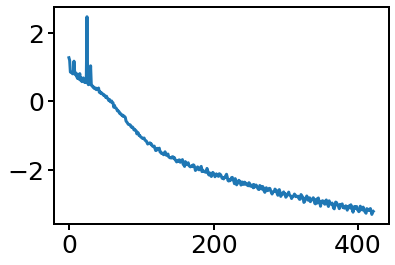

In [1645]:
plt.plot(np.array(loss_run).sum(-1))
#plt.yscale("log")

In [ ]:
# full samplign 

In [1471]:
samples.shape

torch.Size([398, 2048, 1])

In [1623]:
# full sampling 
t

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000], device='cuda:0')

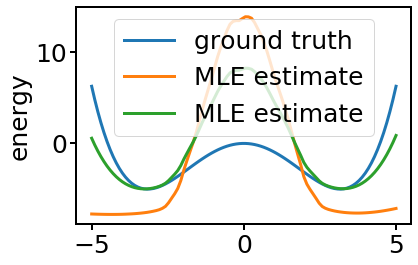

In [1627]:
linsp = torch.linspace(-5.,5.)[:, None]
plt.plot(linsp, harm1d(linsp, t), label='ground truth')
plt.plot(linsp, h.E(linsp.to(DEVICE)).detach().cpu().numpy()-2.6, label='MLE estimate')
plt.plot(linsp, 0.5 * (h.E(linsp.to(DEVICE)).detach().cpu().numpy() + harm1d(linsp, t).detach().cpu().numpy())
         , label='MLE estimate')
plt.legend()
plt.ylabel("energy")
#plt.ylim(-6, 17)
plt.show()

In [1418]:
f_x.model.tau

2

In [1419]:
f_x.model.tau

2

In [1540]:
DEVICE = 0
num_chains = 3
tau = 50
dt = 0.1
t_len = int( tau / dt )

B = 2 ** 15

# sample from normal distribution and deform 
p_v = torch.empty(B, 3).normal_(mean=0,std=1)
q = torch.empty(B, 1).normal_(mean=0,std=1) 
p = torch.empty(B, 1).normal_(mean=0,std=1)
W = torch.zeros(B, 1).to(DEVICE)
Q = torch.zeros(B, 1).to(DEVICE)

f_x.model.tau = tau

pq = torch.cat((p, q, p_v), dim=1).to(DEVICE)
pq.requires_grad= True

t = torch.Tensor([dt * i for i in range(t_len)]).to(DEVICE)
x, W_traj, Q_traj = odeint(f_x, (pq, W, Q), t, method='rk4')


/home/wwj/anaconda3/envs/nff/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/wwj/anaconda3/envs/nff/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


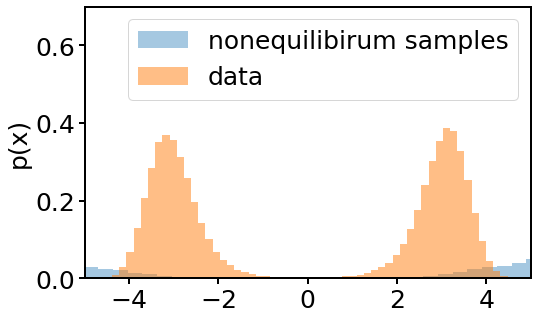

In [1541]:
plt.figure(figsize=(8,5))
plt.hist(x[-1, :, 1 ].detach().cpu().numpy(),bins=100, normed=True, alpha=0.4, label='nonequilibirum samples')
plt.hist(data, bins=60, alpha=0.5, normed=True, label='data')
plt.ylabel("p(x)")
plt.xlim(-5,5)
plt.ylim(0, 0.7)
plt.legend()
plt.show()

0.01
0.02
0.05
0.1
0.2


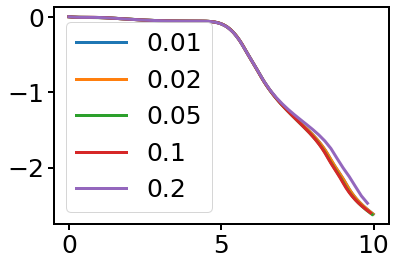

In [631]:
# check for convergence of time step
# sample from normal distribution and deform 
B = 4
p_v = torch.empty(B, 3).normal_(mean=0,std=1)
q = torch.empty(B, 1).normal_(mean=0,std=1) 
p = torch.empty(B, 1).normal_(mean=0,std=1)
W = torch.zeros(B, 1).to(DEVICE)
Q = torch.zeros(B, 1).to(DEVICE)

pq = torch.cat((p, q, p_v), dim=1).to(DEVICE)
pq.requires_grad= True


for dt in [0.01, 0.02, 0.05, 0.1, 0.2]:
    print(dt)
    tau = 10
    t_len = int( tau / dt )
    t = torch.Tensor([dt * i for i in range(t_len)]).to(DEVICE)
    x, W_traj, Q_traj = odeint(f_x, (pq, W, Q), t, method='rk4')

    #sample_nll = h.net(x[-1, :, [1]])

    #logZ = -torch.log( torch.exp(-W_traj[-1].reshape(-1)).mean() )
    plt.plot(t.detach().cpu().numpy(), W_traj[:, 0, 0].detach().cpu().numpy(), label=str(dt))
    #plt.show()

plt.legend()
plt.show()

In [629]:
W_traj.shape

torch.Size([1000, 4, 1])

In [630]:
W_traj[:, 0, 1].detach().cpu().numpy()

IndexError: index 1 is out of bounds for dimension 2 with size 1